# Cross Sections of MNIST Decision Cells

## Imports and data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch
import jupyter_black
from sklearn.decomposition import PCA
import random
import torch.utils.data as data

from data_generators import data_loader_MNIST
from model_classes import LeNet
from tools import train
from plotting_tools import plot_results, plot_reg_results

jupyter_black.load()

c:\Users\aslak\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Loading MNIST dataset
in_channels = 1
train_loader, test_loader = data_loader_MNIST()

### Hyperparameters

In [5]:
lr = 0.01
momentum = 0.9

### Training models with and without regularization

In [6]:
model_no_reg = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
model_l2_reg = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
model_jacobi_reg = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 5
losses1, reg_losses1, epochs1, weights1, train_accuracies1, test_accuracies1 = train(
    train_loader, test_loader, model_no_reg, n_epochs
)
losses2, reg_losses2, epochs2, weights2, train_accuracies2, test_accuracies2 = train(
    train_loader, test_loader, model_l2_reg, n_epochs, l2=True, l2_lmbd=0.0005
)
losses3, reg_losses3, epochs3, weights3, train_accuracies3, test_accuracies3 = train(
    train_loader,
    test_loader,
    model_jacobi_reg,
    n_epochs,
    jacobi_reg=True,
    jacobi_reg_lmbd=0.01,
)

Epoch: 0
Accuracy of the network on the test images: 83 %
Epoch: 1
Accuracy of the network on the test images: 93 %
Epoch: 2
Accuracy of the network on the test images: 96 %
Epoch: 3
Accuracy of the network on the test images: 96 %
Epoch: 4
Accuracy of the network on the test images: 97 %
Epoch: 0
Accuracy of the network on the test images: 74 %
Epoch: 1
Accuracy of the network on the test images: 76 %
Epoch: 2
Accuracy of the network on the test images: 77 %
Epoch: 3
Accuracy of the network on the test images: 96 %
Epoch: 4
Accuracy of the network on the test images: 97 %
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 0
Accuracy of the network on the test images: 89 %
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Ep

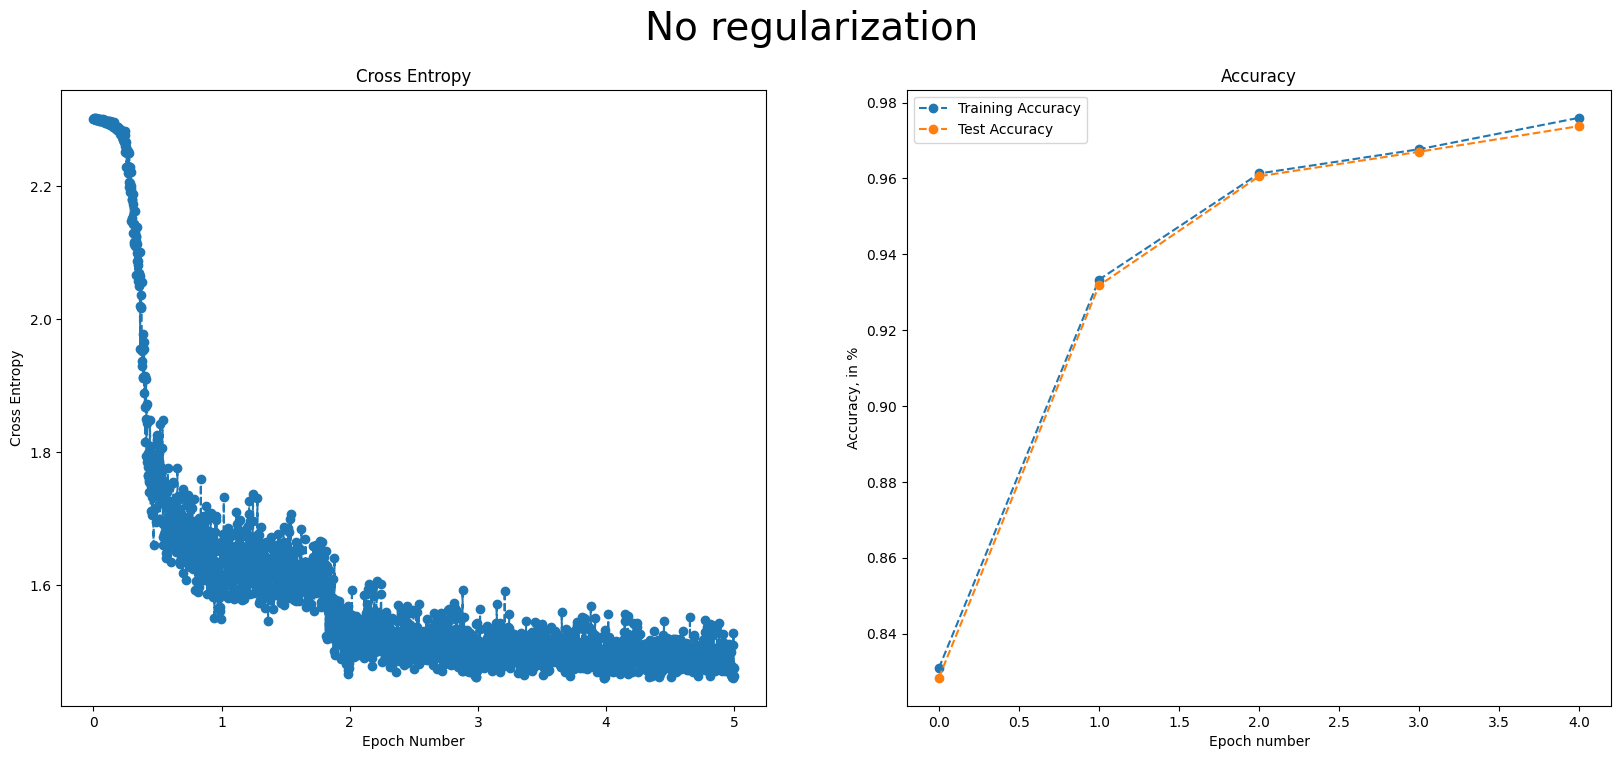

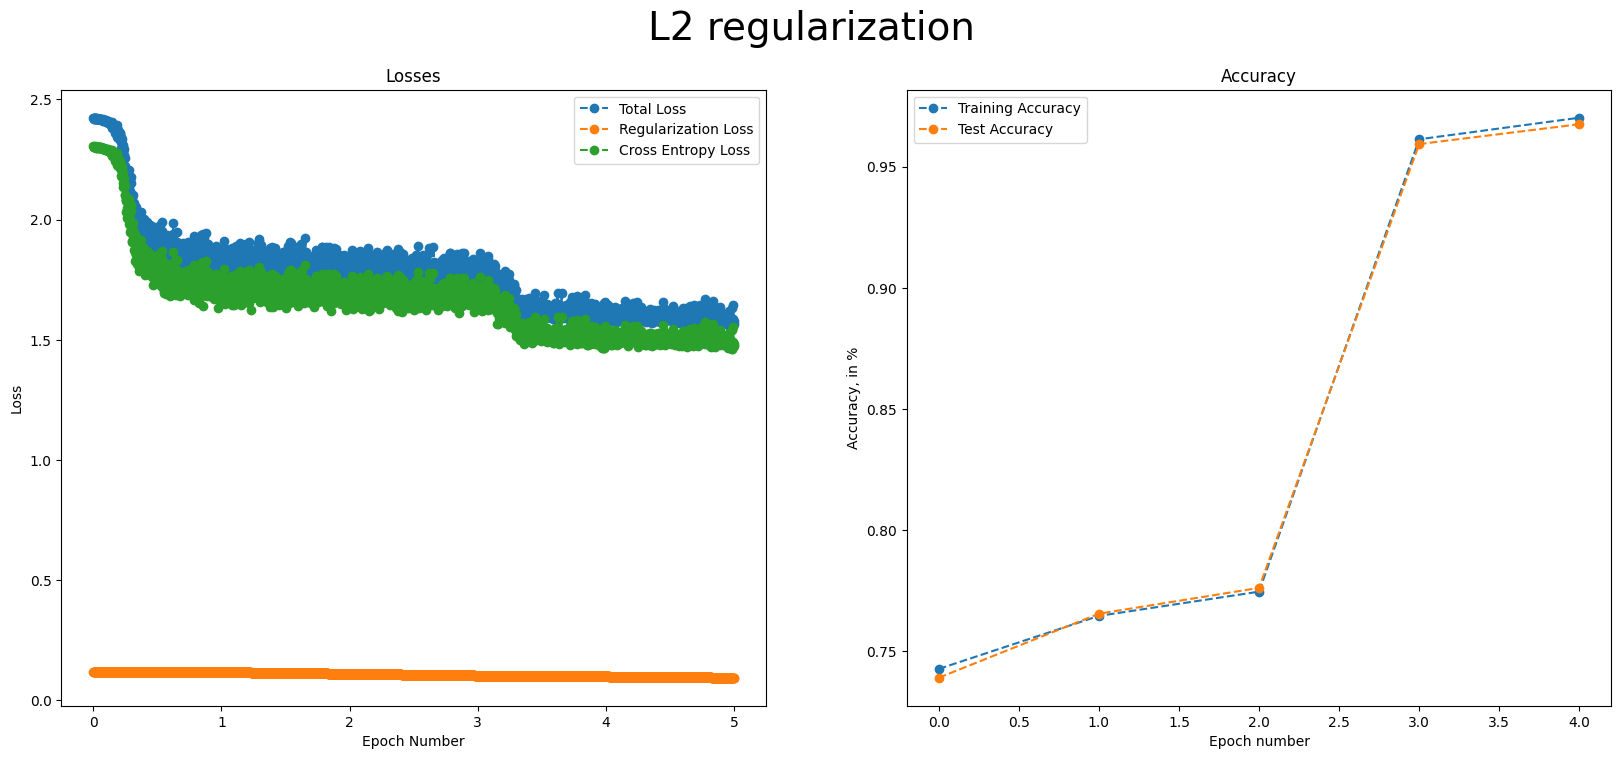

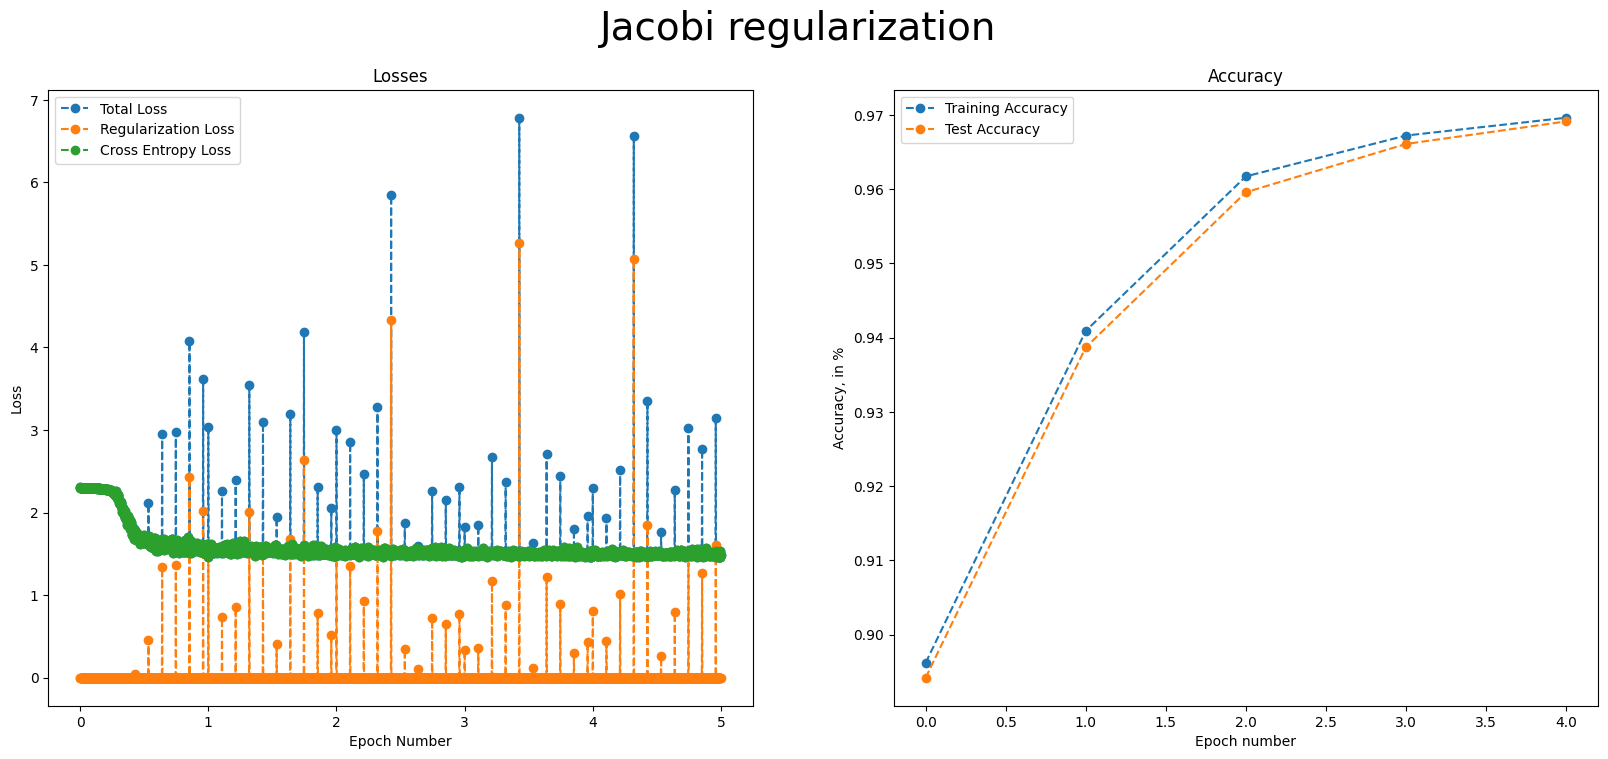

In [16]:
plot_results(
    epochs1, losses1, train_accuracies1, test_accuracies1, title="No regularization"
)
plot_reg_results(
    epochs2,
    losses2,
    reg_losses2,
    train_accuracies2,
    test_accuracies2,
    title="L2 regularization",
)
plot_reg_results(
    epochs3,
    losses3,
    reg_losses3,
    train_accuracies3,
    test_accuracies3,
    title="Jacobi regularization",
)

### Finding cross-sections

In [8]:
def perform_pca(train_loader):
    """Perform PCA on the data in train_loader."""
    train_data = []
    train_labels = []

    for image, labels in train_loader:
        train_data.append(image.view(-1, 32 * 32).numpy())
        train_labels.append(labels.numpy())

    train_data = np.concatenate(train_data)
    train_labels = np.concatenate(train_labels)

    pca = PCA(n_components=2)
    pca.fit(train_data)

    return pca

In [9]:
def select_random_test_sample(test_loader):
    """Get random sample from test_loader."""

    # Get the length of the test dataset
    test_dataset = test_loader.dataset
    num_test_samples = len(test_dataset)

    # Create a random sampler for the test dataset
    random_sampler = data.RandomSampler(test_dataset)

    # Choose a random index from the test dataset
    random_index = random.randint(0, num_test_samples - 1)

    # Get the random test sample using the random index
    sample = test_dataset[random_index][0].unsqueeze(0)
    return sample

In [10]:
def calculate_sample_boundary_distance(probs, grid_size, grid, sample_pca):
    # Calculate the distance to the boundary for each point in the grid
    sorted_probs, _ = torch.sort(probs, descending=True, dim=1)
    dist_to_boundary = sorted_probs[:, 0] - sorted_probs[:, 1]

    # Find the distance to the boundary for the test sample
    dist_to_boundary_grid = dist_to_boundary.view(grid_size, grid_size)
    sample_boundary_distance = dist_to_boundary_grid[
        np.unravel_index(
            np.argmin(
                np.linalg.norm(grid - sample_pca, axis=1).reshape(grid_size, grid_size)
            ),
            (grid_size, grid_size),
        )
    ]
    return sample_boundary_distance


def plot_circle(ax, sample_boundary_distance, sample_pca):

    # Plot the test sample with a circle indicating the closest decision boundary
    circle = plt.Circle(
        (sample_pca[0, 0], sample_pca[0, 1]),
        sample_boundary_distance * 5,
        color="k",
        fill=False,
    )
    ax.add_artist(circle)

In [11]:
def plot_point(ax, sample_pca):
    ax.scatter(
        sample_pca[0, 0],
        sample_pca[0, 1],
        c="k",
        marker="o",
        s=100,
        edgecolors="w",
        linewidths=1,
    )

In [12]:
def center_plot(ax, sample_pca, sample_boundary_distance):
    multiplier = 100
    ax.set_xlim(
        sample_pca[0, 0] - multiplier * sample_boundary_distance,
        sample_pca[0, 0] + multiplier * sample_boundary_distance,
    )
    ax.set_ylim(
        sample_pca[0, 1] - multiplier * sample_boundary_distance,
        sample_pca[0, 1] + multiplier * sample_boundary_distance,
    )

In [13]:
def visualize_decision_cells(
    model, train_loader, test_loader, regularization=None, seed=None
):
    """Visualize the decision boundaries of a model using PCA for dimensionality reduction."""

    if seed is not None:
        np.random.seed(seed)

    pca = perform_pca(train_loader)
    sample = select_random_test_sample(test_loader)

    # Flatten the sample and project it onto the principal components
    sample_flat = sample.view(-1).detach().numpy().squeeze()
    sample_pca = pca.transform(sample_flat.reshape(1, -1))

    # Create a grid in the chosen dimensions
    grid_size = 100
    xx, yy = np.meshgrid(
        np.linspace(-10, 10, grid_size), np.linspace(-10, 10, grid_size)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Transform the grid back to the input space
    grid_inverse = pca.inverse_transform(grid)
    input_space = torch.tensor(grid_inverse, dtype=torch.float32)

    # Calculate the model predictions and softmax probabilities
    with torch.no_grad():
        output = model(input_space.view(-1, 1, 32, 32))
        probs = torch.softmax(output, dim=1)

    # Find the maximum probability and corresponding class
    max_probs, max_classes = torch.max(probs, 1)

    # Normalize max_probs to the range [0, 1]
    max_probs_norm = (max_probs - max_probs.min()) / (max_probs.max() - max_probs.min())
    max_classes_norm = (max_classes - max_classes.min()) / (
        max_classes.max() - max_classes.min()
    )

    # Create the scatter plot with the calculated grid probabilities
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = plt.cm.rainbow(np.linspace(0, 1, 10))
    levels = np.linspace(0, 10, 10)

    # Plot filled contours at specified levels
    ax.contour(
        xx,
        yy,
        max_classes.reshape(xx.shape),
        colors="black",
        levels=levels,
        linewidths=0.2,
    )

    ax.contourf(
        xx,
        yy,
        max_classes.reshape(xx.shape),
        levels=levels,
        colors=colors,
    )

    sample_boundary_distance = calculate_sample_boundary_distance(
        probs, grid_size, grid, sample_pca
    )
    plot_circle(ax, sample_boundary_distance, sample_pca)
    plot_point(ax, sample_pca)

    ax.set_title(
        f"Decision Cells Visualization ({regularization or 'No Regularization'})"
    )

    # Create a legend with the label for each class

    handles = []
    for i in range(10):
        handle = Patch(color=colors[i], label=str(i))
        handles.append(handle)
    ax.legend(handles=handles)

    # Center the plot around the point and the circle
    center_plot(ax, sample_pca, sample_boundary_distance)

    plt.show()

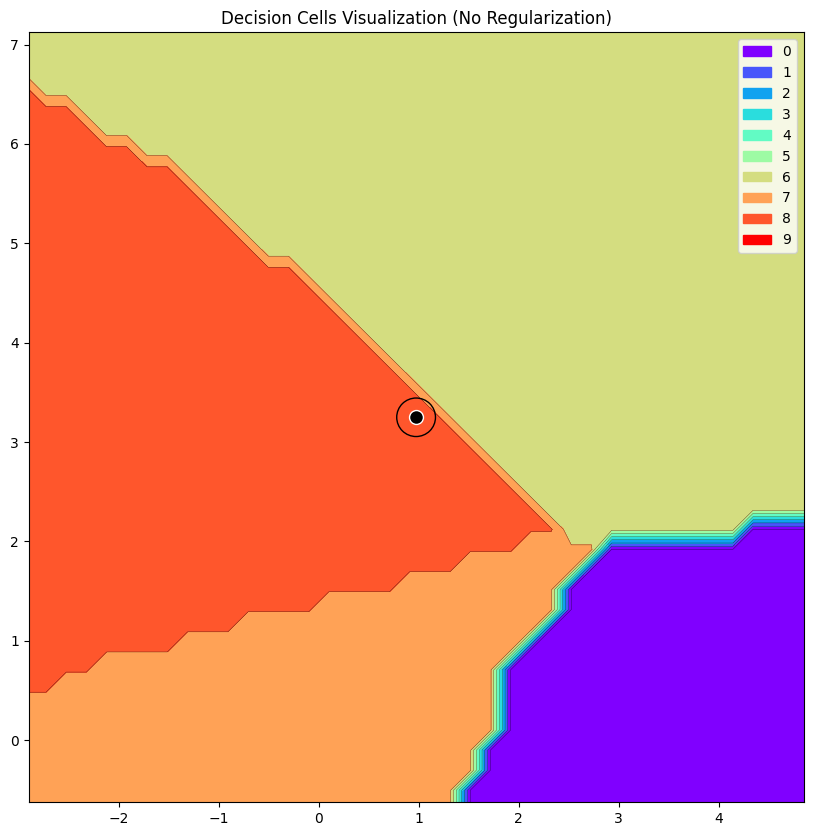

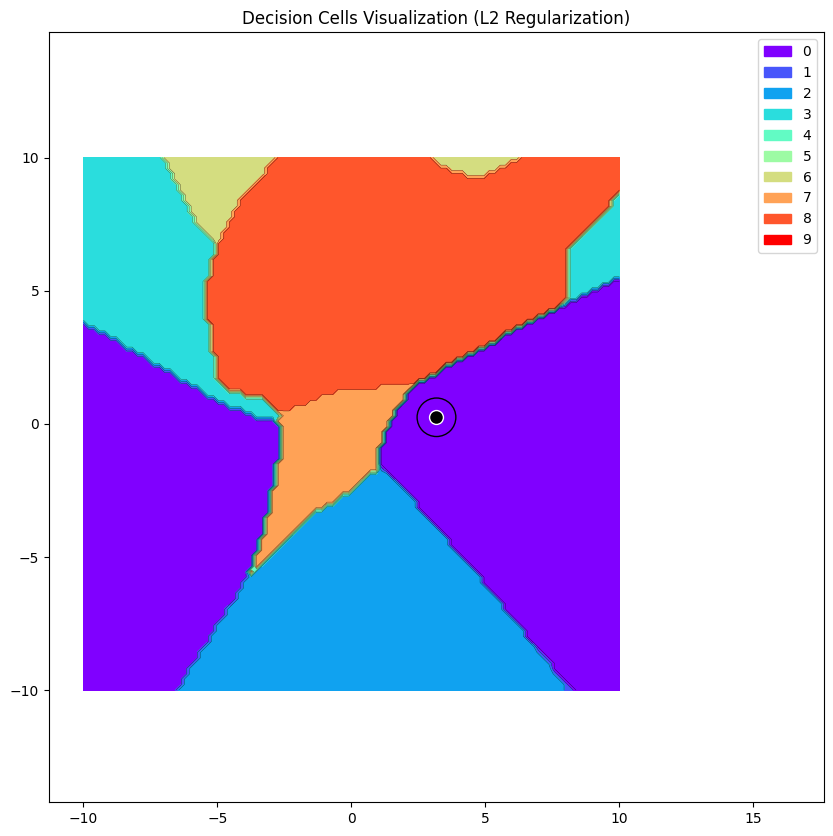

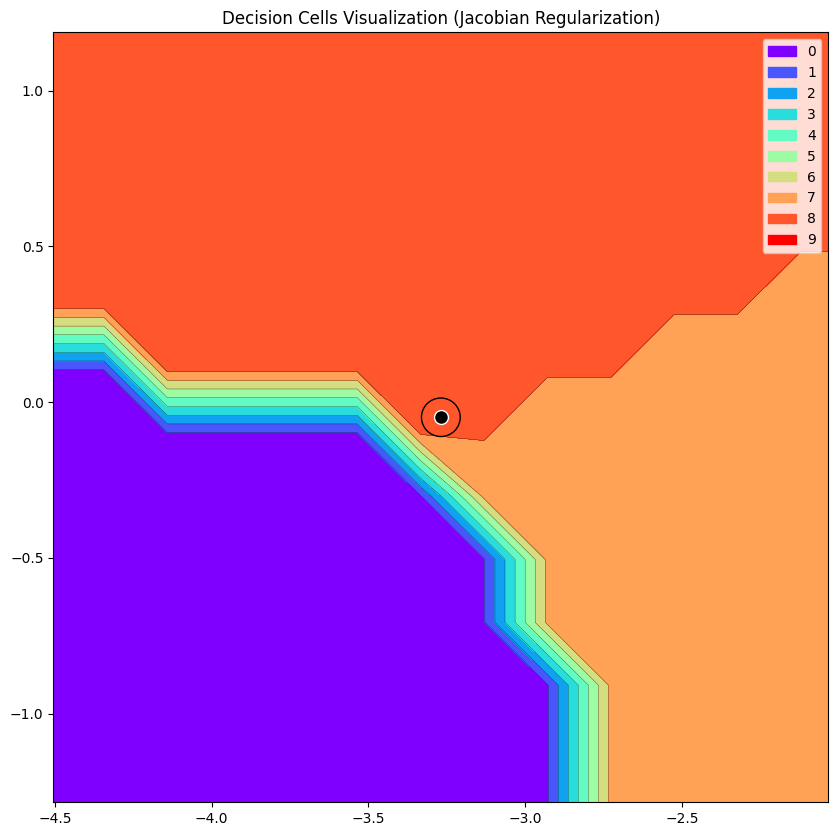

In [14]:
# Visualize decision cells without regularization
seed = 200
visualize_decision_cells(
    model_no_reg, train_loader, test_loader, regularization=None, seed=seed
)

# Visualize decision cells with L2 regularization
visualize_decision_cells(
    model_l2_reg,
    train_loader,
    test_loader,
    regularization="L2 Regularization",
    seed=seed,
)

# Visualize decision cells with Jacobian regularization
visualize_decision_cells(
    model_jacobi_reg,
    train_loader,
    test_loader,
    regularization="Jacobian Regularization",
    seed=seed,
)